In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from keras import Model
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_curve, roc_auc_score, confusion_matrix
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, ReLU, Input, BatchNormalization, Conv2D, GlobalMaxPooling2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.data import Dataset
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import os
import glob
import cv2
import random
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
tf.random.set_seed(3957)
%matplotlib inline

In [2]:
sns.set(style="darkgrid")
plt.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = (10, 10)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
directory = '/content/drive/MyDrive/JSWut'
batch_size = 64

In [5]:
def detailed_report(y_true, y_pred):
  report = {}
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  tpr = tp / (tp + fn)
  spc = tn / (fp + tn)
  ppv = tp / (tp + fp)
  npv = tn / (tn + fn)
  fpr = fp / (fp + tn)
  fdr = fp / (fp + tp)
  fnr = fn / (fn + tp)
  acc = (tp + tn) / (fp + tp + fn + tn)
  f1 = (2 * tp) / ((2 * tp) + fp + fn)
  mcc = ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
  report["Sensitivity"] = tpr 
  report["Specificity"] = spc
  report["Precision"] = ppv
  report["Negative Predictive Value"] = npv
  report["False Positive Rate"] = fpr
  report["False Discovery Rate"] = fdr
  report["False Negative Rate"] = fnr
  report["Accuracy"] = acc
  report["F1-Score"] = f1
  report["Matthews Correlation Coefficient"] = mcc
  return report

In [6]:
class JSImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, file_type='.js', RGB=False, batch_size=16, shuffle=False, max_dimension=None, X=None, y=None):        
        
        self.directories = directory
        self.batch_size = batch_size
        self.shuffle = shuffle
        if not max_dimension:
          self.max_dimension = 32
        else:
          self.max_dimension = max_dimension
        if not X:
          self.image_paths = [f for f in glob.glob(directory + f"*/*/*{file_type}", recursive=True) if os.path.isfile(f)]
        else:
          self.image_paths = X
        if not y:
          self.class_labels = [1 if 'malicious' in f else 0 for f in self.image_paths]
        else:
          self.class_labels = y

        self.RGB = RGB
        self.image_paths = np.array(self.image_paths)
        self.class_labels = np.array(self.class_labels)
        self.true_labels = np.array([])

        #index array for shuffling data
        self.idx = np.arange(len(self.image_paths))
        
    
    def __len__(self):
        
        #number of batches in an epoch
        return int(np.ceil(len(self.image_paths)/float(self.batch_size)))
    
    
    def _load_image(self, img_path, save=False):
        max_dim = self.max_dimension      
        img = np.fromfile(img_path, dtype=np.uint8)

        max_dim = int(np.ceil(np.sqrt(len(img))))
        while max_dim ** 2 < len(img):
          max_dim += 1

        max_res = max_dim ** 2
        times = int(np.ceil(max_res/len(img)))
        img = np.tile(img, times)[:max_res]
        img = img.reshape(max_dim, max_dim)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
        img = np.reshape(img, (224, 224, 1))
        if save:
          with open(f'{img_path}.img', 'wb')  as fp_i:
            np.save(fp_i, img)
        if self.RGB:
          img = np.dstack((img, img, img))          
        return preprocess_input(img)
    
    def on_epoch_end(self):
      if self.shuffle:
        np.random.shuffle(self.idx)


    def __getitem__(self, index):
        batch_image_paths = self.image_paths[self.idx[index *self.batch_size:(index + 1) * self.batch_size]]
        batch_class_labels = self.class_labels[self.idx[index *self.batch_size:(index + 1) * self.batch_size]]

        batch_images = [self._load_image(image_path) for image_path in batch_image_paths]
        self.true_labels = np.append(self.true_labels, batch_class_labels)
        return np.asarray(batch_images), np.asarray(batch_class_labels)


    def transform(self):
        images = [self._load_image(image_path, save=True) for image_path in self.image_paths]
        print('[*] Transformation complete')    

In [7]:
X = [f for f in glob.glob(directory + "*/*/*.bc", recursive=True) if os.path.isfile(f)]

In [8]:
X_temp = [f for f in glob.glob(directory + "*/*/*.bc", recursive=True) if (os.path.isfile(f) and 'benign' in f)] * 2
random.shuffle(X_temp)
random.shuffle(X_temp)
X += X_temp

In [9]:
y = [1 if 'malicious' in f else 0 for f in X]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=55555)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.63, random_state=55555)

In [11]:
print(f"""Dataset info:
----------------------------
Training set: {len(X_train)} (Malicious: {y_train.count(1)}, Benign: {y_train.count(0)})
Validation set: {len(X_val)} (Malicious: {y_val.count(1)}, Benign: {y_val.count(0)})
Testing set: {len(X_test)} (Malicious: {y_test.count(1)}, Benign: {y_test.count(0)})
""")

Dataset info:
----------------------------
Training set: 2471 (Malicious: 1315, Benign: 1156)
Validation set: 1452 (Malicious: 780, Benign: 672)
Testing set: 981 (Malicious: 526, Benign: 455)



In [12]:
train_gen = JSImageGenerator(directory, RGB=True, batch_size=batch_size, X=X_train, y=y_train)
val_gen = JSImageGenerator(directory, RGB=True, batch_size=batch_size, X=X_val, y=y_val)
test_gen = JSImageGenerator(directory, RGB=True, batch_size=batch_size, X=X_test, y=y_test)

In [13]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
save_name = 'JS-CNN'

In [15]:
res50 = ResNet50(include_top=False, weights='imagenet')

In [16]:
x = res50.output
x = GlobalAveragePooling2D()(x)
x = Dense(10)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [17]:
model = Model(inputs=res50.input, outputs=predictions)

In [18]:
# Freeze top layers
for layer in res50.layers:
    layer.trainable = False

In [19]:
adam = Adam(learning_rate=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])

In [20]:
history = model.fit(train_gen, batch_size=batch_size, epochs=15, validation_data=val_gen)

Epoch 1/15
39/39 [==============================] - 36s 738ms/step - loss: 0.3477 - acc: 0.8551 - f1_m: 0.8534 - precision_m: 0.8547 - recall_m: 0.9007 - val_loss: 0.1325 - val_acc: 0.9725 - val_f1_m: 0.9732 - val_precision_m: 0.9799 - val_recall_m: 0.9677
Epoch 2/15
39/39 [==============================] - 25s 635ms/step - loss: 0.1121 - acc: 0.9761 - f1_m: 0.9770 - precision_m: 0.9802 - recall_m: 0.9745 - val_loss: 0.1014 - val_acc: 0.9780 - val_f1_m: 0.9784 - val_precision_m: 0.9861 - val_recall_m: 0.9717
Epoch 3/15
39/39 [==============================] - 25s 635ms/step - loss: 0.1031 - acc: 0.9757 - f1_m: 0.9768 - precision_m: 0.9809 - recall_m: 0.9736 - val_loss: 0.0922 - val_acc: 0.9752 - val_f1_m: 0.9759 - val_precision_m: 0.9800 - val_recall_m: 0.9728
Epoch 4/15
39/39 [==============================] - 25s 635ms/step - loss: 0.0924 - acc: 0.9777 - f1_m: 0.9789 - precision_m: 0.9825 - recall_m: 0.9759 - val_loss: 0.0874 - val_acc: 0.9759 - val_f1_m: 0.9767 - val_precision_m: 0.

In [21]:
# Last 2 convolutional blocks
for layer in res50.layers[:165]:
   layer.trainable = False
   
for layer in res50.layers[165:]:
   layer.trainable = True

In [22]:
adam = Adam(learning_rate=1e-5)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])

In [23]:
# Using bytecode of JavaScript file as image
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/JS-CNN-Custom/ResNet50_JSBC+Bal_checkpoint_{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_f1_m', mode='max')
csv_logger = CSVLogger(f'/content/drive/MyDrive/JS-CNN-Custom/ResNet50_JSBC+Bal_training_set_iranalysis_{save_name}.csv',separator=',', append=False)
early_stopper = EarlyStopping(monitor='val_f1_m', patience=10, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=1e-6, cooldown=1, patience=8, min_lr=1e-4, verbose=1)

history = model.fit(train_gen, batch_size=batch_size, epochs=50, validation_data=val_gen,callbacks=[checkpointer, csv_logger, early_stopper, lr_reducer])
model.save(f'/content/drive/MyDrive/JS-CNN-Custom/{save_name}_ResNet50_JSBC+Bal_2_cnn.hdf5')

Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.4814 - acc: 0.9377 - f1_m: 0.9432 - precision_m: 0.9071 - recall_m: 0.9893
Epoch 00001: val_f1_m improved from -inf to 0.90273, saving model to /content/drive/MyDrive/JS-CNN-Custom/ResNet50_JSBC+Bal_checkpoint_01.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


39/39 [==============================] - 34s 741ms/step - loss: 0.4814 - acc: 0.9377 - f1_m: 0.9432 - precision_m: 0.9071 - recall_m: 0.9893 - val_loss: 0.3675 - val_acc: 0.9056 - val_f1_m: 0.9027 - val_precision_m: 0.9939 - val_recall_m: 0.8278 - lr: 1.0000e-05
Epoch 2/50
39/39 [==============================] - ETA: 0s - loss: 0.1736 - acc: 0.9749 - f1_m: 0.9761 - precision_m: 0.9743 - recall_m: 0.9787
Epoch 00002: val_f1_m did not improve from 0.90273
39/39 [==============================] - 26s 662ms/step - loss: 0.1736 - acc: 0.9749 - f1_m: 0.9761 - precision_m: 0.9743 - recall_m: 0.9787 - val_loss: 0.6495 - val_acc: 0.8402 - val_f1_m: 0.8226 - val_precision_m: 0.9923 - val_recall_m: 0.7050 - lr: 1.0000e-05
Epoch 3/50
39/39 [==============================] - ETA: 0s - loss: 0.1157 - acc: 0.9781 - f1_m: 0.9790 - precision_m: 0.9807 - recall_m: 0.9779
Epoch 00003: val_f1_m did not improve from 0.90273
39/39 [==============================] - 26s 662ms/step - loss: 0.1157 - acc: 0.97

In [24]:
scores = model.evaluate(test_gen, verbose=1)
scores

16/16 [==============================] - 7s 431ms/step - loss: 0.0443 - acc: 0.9766 - f1_m: 0.9779 - precision_m: 0.9926 - recall_m: 0.9644


[0.044343121349811554,
 0.9765545129776001,
 0.9778665900230408,
 0.9926377534866333,
 0.964440643787384]

In [25]:
# test_gen.true_labels.shape
y_true = test_gen.class_labels

In [26]:
%%time
y_pred = model.predict(test_gen).ravel()

CPU times: user 9.62 s, sys: 299 ms, total: 9.92 s
Wall time: 7.51 s


In [27]:
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

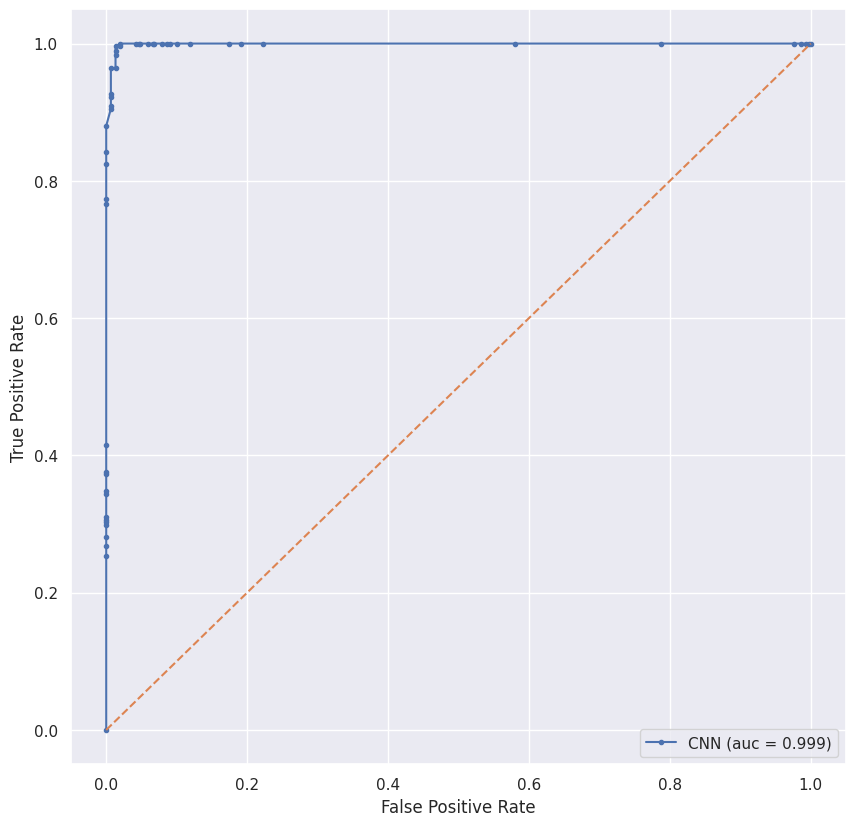

In [28]:
nn_fpr, nn_tpr, _ = roc_curve(y_true, y_pred) # nn_thresholds
nn_auc = roc_auc_score(y_true, y_pred)
plt.plot(nn_fpr, nn_tpr, marker='.', label='CNN (auc = %0.3f)' % nn_auc)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [29]:
scale = lambda x: 1.0 if (x > 0.5) else 0.0
scale_v = np.vectorize(scale)

In [30]:
y_pred_ = scale_v(y_pred)

In [31]:
print(classification_report(y_true, y_pred_))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       455
           1       0.99      0.96      0.98       526

    accuracy                           0.98       981
   macro avg       0.98      0.98      0.98       981
weighted avg       0.98      0.98      0.98       981



In [32]:
import json
rep = json.dumps(detailed_report(y_true, y_pred_), sort_keys=True, indent=4)
print(rep)

{
    "Accuracy": 0.9765545361875637,
    "F1-Score": 0.9778206364513018,
    "False Discovery Rate": 0.007827788649706457,
    "False Negative Rate": 0.03612167300380228,
    "False Positive Rate": 0.008791208791208791,
    "Matthews Correlation Coefficient": 0.9534154358531874,
    "Negative Predictive Value": 0.9595744680851064,
    "Precision": 0.9921722113502935,
    "Sensitivity": 0.9638783269961977,
    "Specificity": 0.9912087912087912
}
